<a href="https://colab.research.google.com/github/noviaputri/Tubes_ImageRetrieval/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data and Library

In [ ]:
# import the necessary packages
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from skimage.exposure import rescale_intensity
import numpy as np
import argparse

In [ ]:
uploaded = files.upload()

Saving AM157L.jpg to AM157L.jpg


In [ ]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "AM157L.jpg",
  "scharr": 0
}

# Adaptive Thresholding

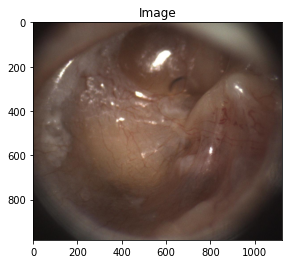

In [ ]:
# load the image and display it
image = cv2.imread(args["image"])
plt_imshow("Image", image)

# convert the image to grayscale and blur it slightly
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

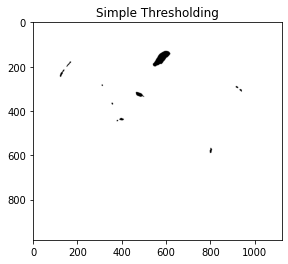

In [ ]:
# apply simple thresholding with a hardcoded threshold value
(T, threshInv) = cv2.threshold(blurred, 230, 255,
	cv2.THRESH_BINARY_INV)
plt_imshow("Simple Thresholding", threshInv)

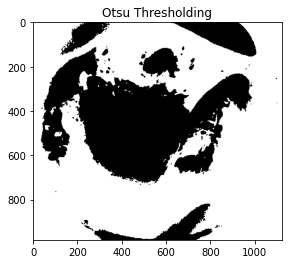

In [ ]:
# apply Otsu's automatic thresholding
(T, threshInv) = cv2.threshold(blurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt_imshow("Otsu Thresholding", threshInv)

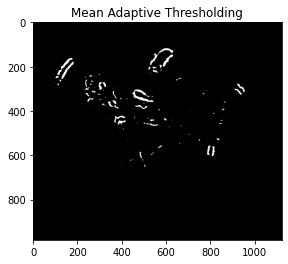

In [ ]:

# instead of manually specifying the threshold value, we can use
# adaptive thresholding to examine neighborhoods of pixels and
# adaptively threshold each neighborhood
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
plt_imshow("Mean Adaptive Thresholding", thresh)

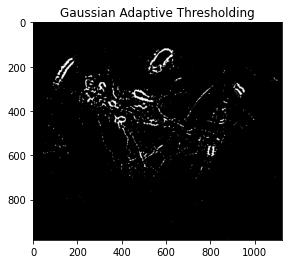

In [ ]:

# perform adaptive thresholding again, this time using a Gaussian
# weighting versus a simple mean to compute our local threshold
# value
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4)
plt_imshow("Gaussian Adaptive Thresholding", thresh)

# Canny

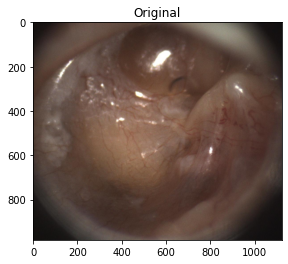

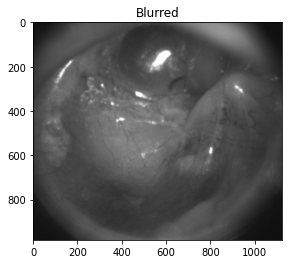

In [ ]:
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# show the original and blurred images
plt_imshow("Original", image)
plt_imshow("Blurred", blurred)

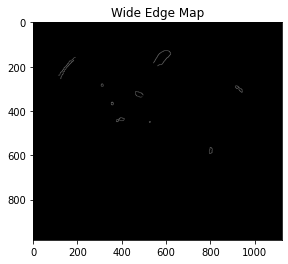

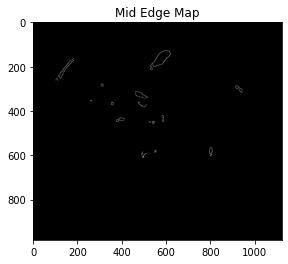

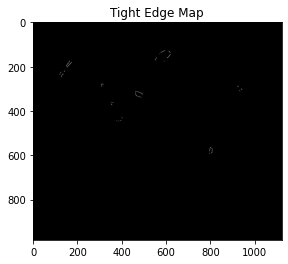

In [ ]:
# compute a "wide", "mid-range", and "tight" threshold for the edges
# using the Canny edge detector
wide = cv2.Canny(blurred, 10, 200)
mid = cv2.Canny(blurred, 30, 150)
tight = cv2.Canny(blurred, 240, 250)

# show the output Canny edge maps
plt_imshow("Wide Edge Map", wide)
plt_imshow("Mid Edge Map", mid)
plt_imshow("Tight Edge Map", tight)

# Color Space

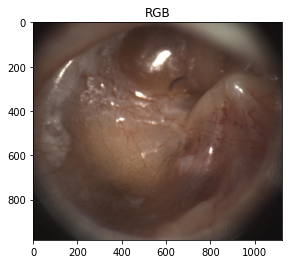

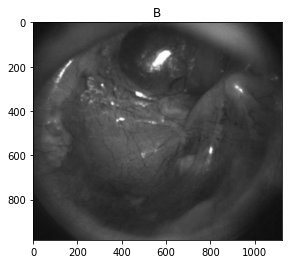

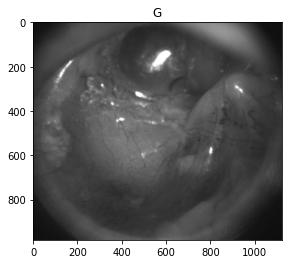

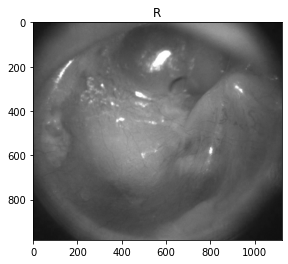

In [ ]:
# load the original image and show it
image = cv2.imread(args["image"])
plt_imshow("RGB", image)

# loop over each of the individual channels and display them
for (name, chan) in zip(("B", "G", "R"), cv2.split(image)):
    plt_imshow(name, chan)

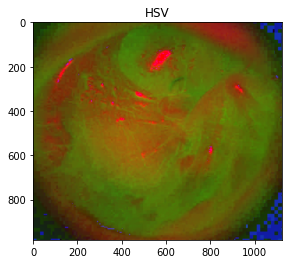

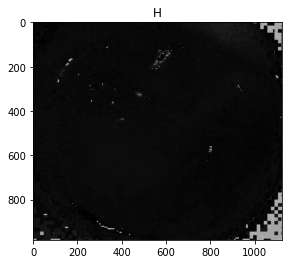

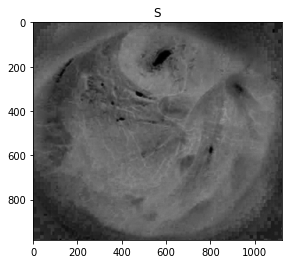

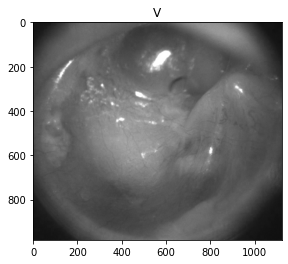

In [ ]:
# convert the image to the HSV color space and show it
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt_imshow("HSV", hsv)

# loop over each of the invidiaul channels and display them
for (name, chan) in zip(("H", "S", "V"), cv2.split(hsv)):
	plt_imshow(name, chan)

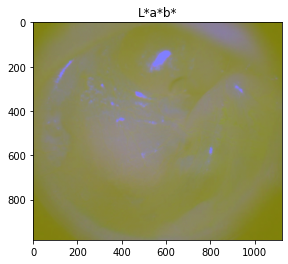

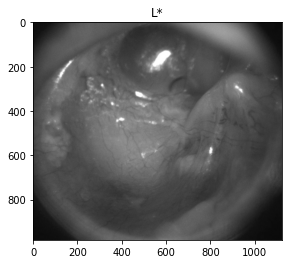

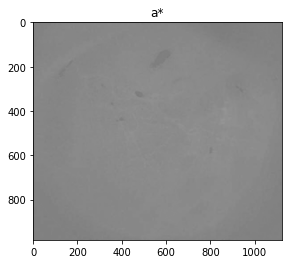

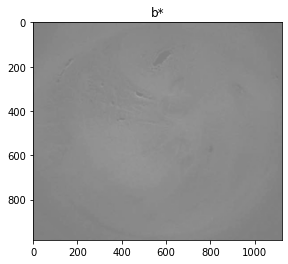

In [ ]:
# convert the image to the L*a*b* color space and show it
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
plt_imshow("L*a*b*", lab)

# loop over each of the invidiaul channels and display them
for (name, chan) in zip(("L*", "a*", "b*"), cv2.split(lab)):
	plt_imshow(name, chan)

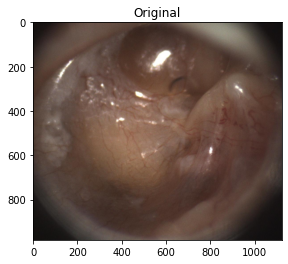

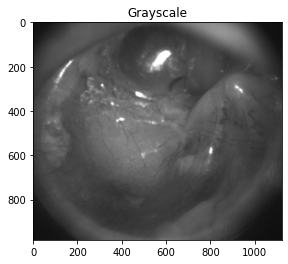

In [ ]:
# show the original and grayscale versions of the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt_imshow("Original", image)
plt_imshow("Grayscale", gray)

# Convolution

In [ ]:
def convolve(image, kernel):
	# grab the spatial dimensions of the image, along with
	# the spatial dimensions of the kernel
	(iH, iW) = image.shape[:2]
	(kH, kW) = kernel.shape[:2]

	# allocate memory for the output image, taking care to
	# "pad" the borders of the input image so the spatial
	# size (i.e., width and height) are not reduced
	pad = (kW - 1) // 2
	image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
		cv2.BORDER_REPLICATE)
	output = np.zeros((iH, iW), dtype="float32")

	# loop over the input image, "sliding" the kernel across
	# each (x, y)-coordinate from left-to-right and top to
	# bottom
	for y in np.arange(pad, iH + pad):
		for x in np.arange(pad, iW + pad):
			# extract the ROI of the image by extracting the
			# *center* region of the current (x, y)-coordinates
			# dimensions
			roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

			# perform the actual convolution by taking the
			# element-wise multiplicate between the ROI and
			# the kernel, then summing the matrix
			k = (roi * kernel).sum()

			# store the convolved value in the output (x,y)-
			# coordinate of the output image
			output[y - pad, x - pad] = k

	# rescale the output image to be in the range [0, 255]
	output = rescale_intensity(output, in_range=(0, 255))
	output = (output * 255).astype("uint8")

	# return the output image
	return output

In [ ]:
# construct average blurring kernels used to smooth an image
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))

# construct a sharpening filter
sharpen = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]), dtype="int")

In [ ]:
# construct the Laplacian kernel used to detect edge-like
# regions of an image
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

# construct the Sobel x-axis kernel
sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

# construct the Sobel y-axis kernel
sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")

In [ ]:
# construct the kernel bank, a list of kernels we're going
# to apply using both our custom `convole` function and
# OpenCV's `filter2D` function
kernelBank = (
	("small_blur", smallBlur),
	("large_blur", largeBlur),
	("sharpen", sharpen),
	("laplacian", laplacian),
	("sobel_x", sobelX),
	("sobel_y", sobelY)
)

[INFO] applying small_blur kernel


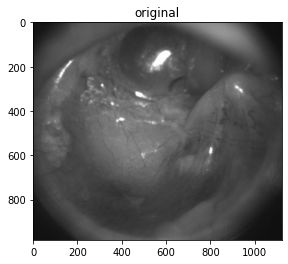

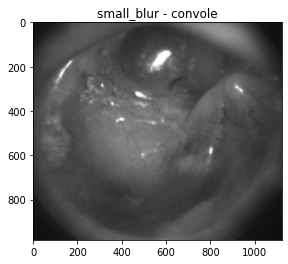

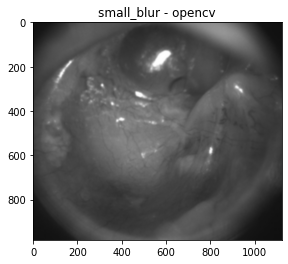

[INFO] applying large_blur kernel


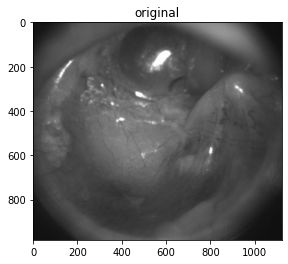

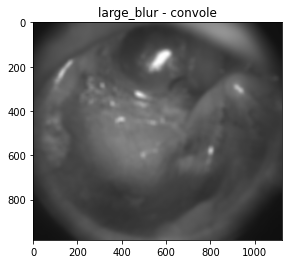

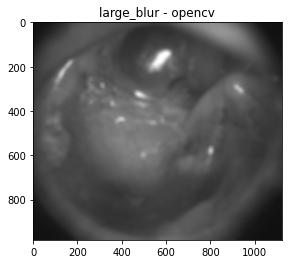

[INFO] applying sharpen kernel


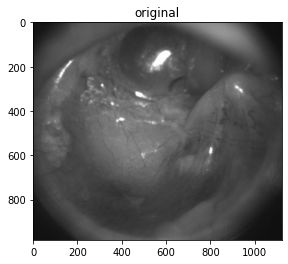

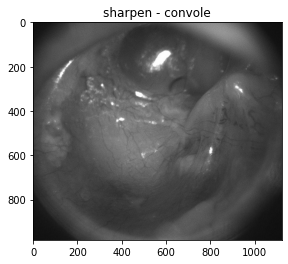

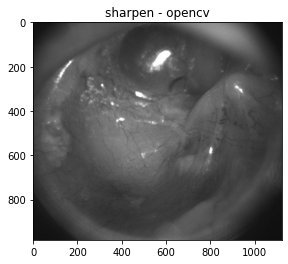

[INFO] applying laplacian kernel


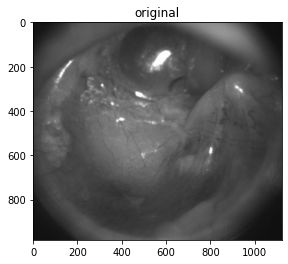

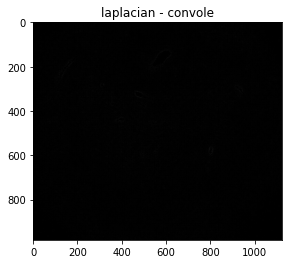

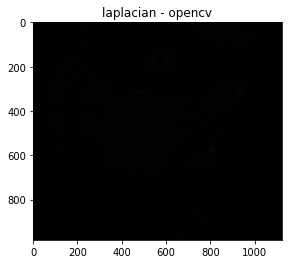

[INFO] applying sobel_x kernel


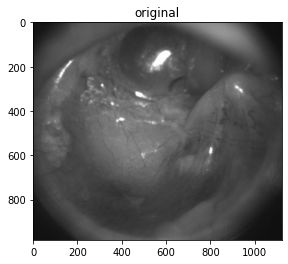

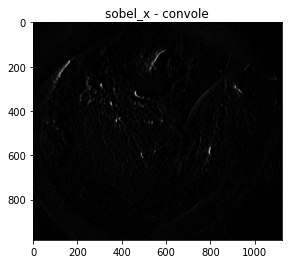

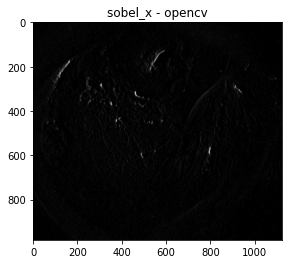

[INFO] applying sobel_y kernel


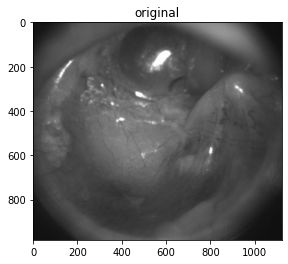

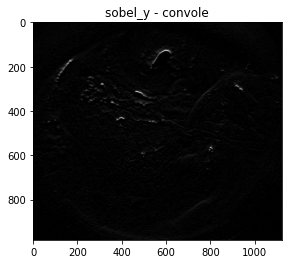

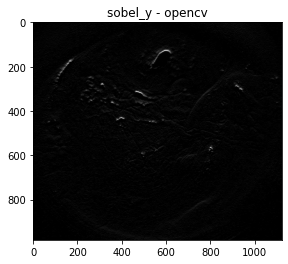

In [ ]:
# load the input image and convert it to grayscale
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# loop over the kernels
for (kernelName, kernel) in kernelBank:
	# apply the kernel to the grayscale image using both
	# our custom `convole` function and OpenCV's `filter2D`
	# function
	print("[INFO] applying {} kernel".format(kernelName))
	convoleOutput = convolve(gray, kernel)
	opencvOutput = cv2.filter2D(gray, -1, kernel)

	# show the output images
	plt_imshow("original", gray)
	plt_imshow("{} - convole".format(kernelName), convoleOutput)
	plt_imshow("{} - opencv".format(kernelName), opencvOutput)

# Gradien

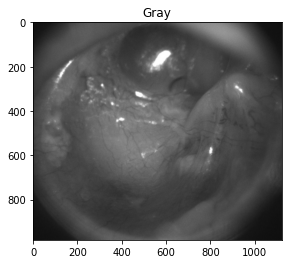

In [ ]:
# load the image, convert it to grayscale, and display the original
# grayscale image
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt_imshow("Gray", gray)

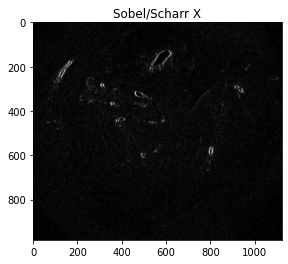

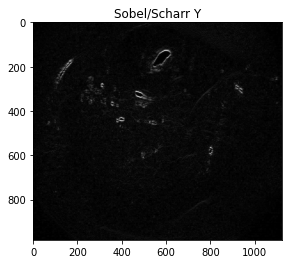

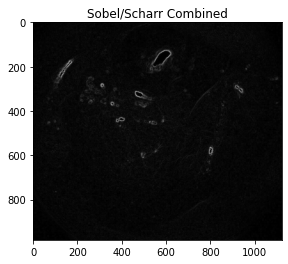

In [ ]:
# set the kernel size, depending on whether we are using the Sobel
# operator of the Scharr operator, then compute the gradients along
# the x and y axis, respectively
ksize = -1 if args["scharr"] > 0 else 3
gX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

# the gradient magnitude images are now of the floating point data
# type, so we need to take care to convert them back a to unsigned
# 8-bit integer representation so other OpenCV functions can operate
# on them and visualize them
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)

# combine the gradient representations into a single image
combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

# show our output images
plt_imshow("Sobel/Scharr X", gX)
plt_imshow("Sobel/Scharr Y", gY)
plt_imshow("Sobel/Scharr Combined", combined)

In [ ]:
# load the input image and convert it to grayscale
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# compute gradients along the x and y axis, respectively
gX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
gY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

# compute the gradient magnitude and orientation
magnitude = np.sqrt((gX ** 2) + (gY ** 2))
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180

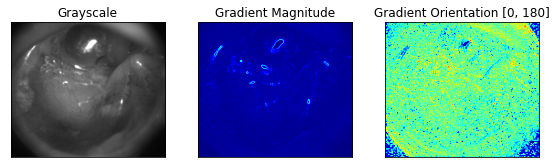

In [ ]:
# initialize a figure to display the input grayscale image along with
# the gradient magnitude and orientation representations, respectively
(fig, axs) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

# plot each of the images
axs[0].imshow(gray, cmap="gray")
axs[1].imshow(magnitude, cmap="jet")
axs[2].imshow(orientation, cmap="jet")

# set the titles of each axes
axs[0].set_title("Grayscale")
axs[1].set_title("Gradient Magnitude")
axs[2].set_title("Gradient Orientation [0, 180]")

# loop over each of the axes and turn off the x and y ticks
for i in range(0, 3):
	axs[i].get_xaxis().set_ticks([])
	axs[i].get_yaxis().set_ticks([])

# show the plots
plt.tight_layout()
plt.show()

# Morphology

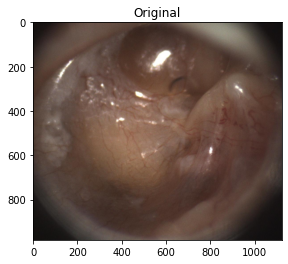

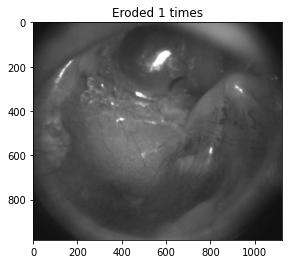

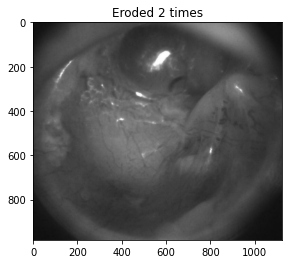

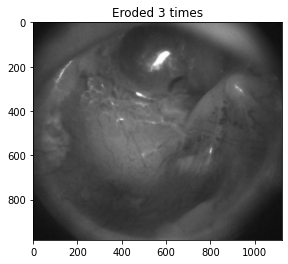

In [ ]:
# load the image, convert it to grayscale, and display it to our
# screen
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt_imshow("Original", image)

# apply a series of erosions
for i in range(0, 3):
	eroded = cv2.erode(gray.copy(), None, iterations=i + 1)
	plt_imshow("Eroded {} times".format(i + 1), eroded)

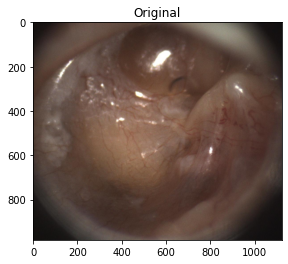

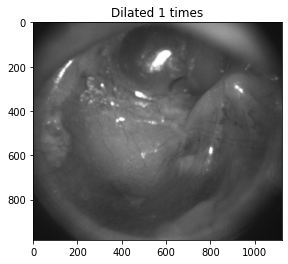

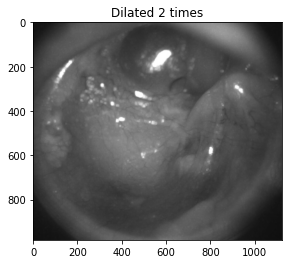

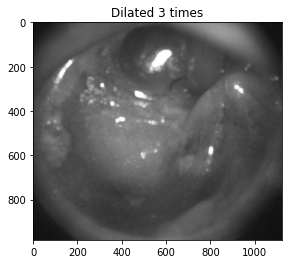

In [ ]:
# display the original image
plt_imshow("Original", image)

# apply a series of dilations
for i in range(0, 3):
	dilated = cv2.dilate(gray.copy(), None, iterations=i + 1)
	plt_imshow("Dilated {} times".format(i + 1), dilated)

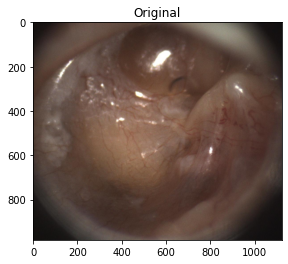

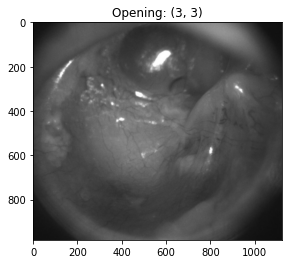

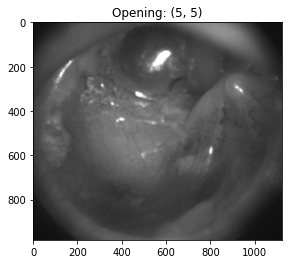

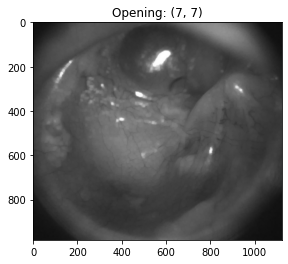

In [ ]:
# close all windows to cleanup the screen, then initialize a list of
# of kernels sizes that will be applied to the image
plt_imshow("Original", image)
kernelSizes = [(3, 3), (5, 5), (7, 7)]

# loop over the kernels sizes
for kernelSize in kernelSizes:
	# construct a rectangular kernel from the current size and then
	# apply an "opening" operation
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
	opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
	plt_imshow("Opening: ({}, {})".format(
		kernelSize[0], kernelSize[1]), opening)

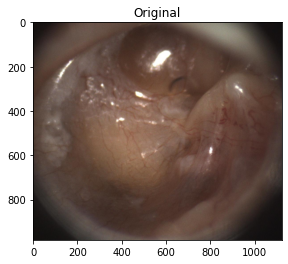

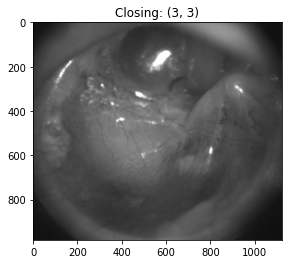

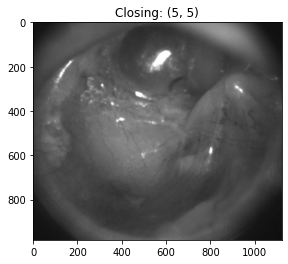

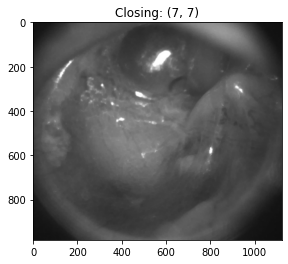

In [ ]:
# display the original image
plt_imshow("Original", image)

# loop over the kernels sizes again
for kernelSize in kernelSizes:
	# construct a rectangular kernel form the current size, but this
	# time apply a "closing" operation
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
	closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
	plt_imshow("Closing: ({}, {})".format(
		kernelSize[0], kernelSize[1]), closing)

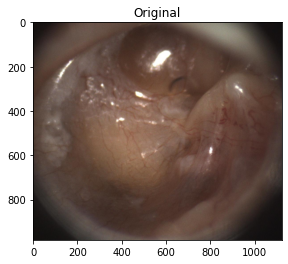

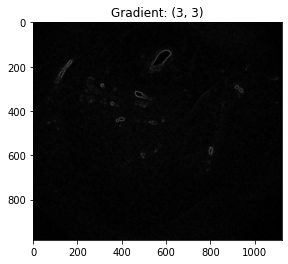

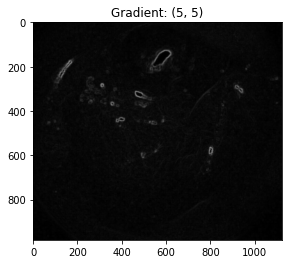

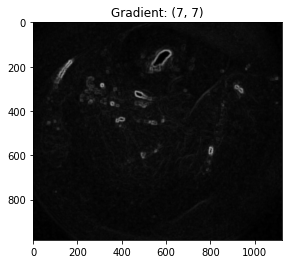

In [ ]:
# display the original image
plt_imshow("Original", image)

# loop over the kernels a final time
for kernelSize in kernelSizes:
	# construct a rectangular kernel and apply a "morphological
	# gradient" operation to the image
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
	gradient = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)
	plt_imshow("Gradient: ({}, {})".format(
		kernelSize[0], kernelSize[1]), gradient)

In [ ]:
# load the image and convert it to grayscale
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# construct a rectangular kernel (13x5) and apply a blackhat
# operation which enables us to find dark regions on a light
# background
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

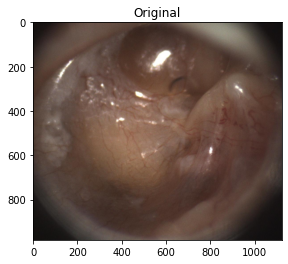

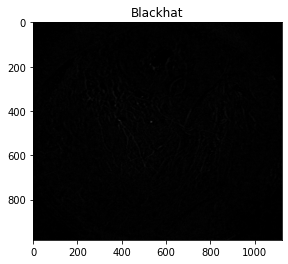

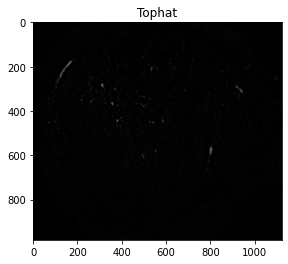

In [ ]:
# similarly, a tophat (also called a "whitehat") operation will
# enable us to find light regions on a dark background
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

# show the output images
plt_imshow("Original", image)
plt_imshow("Blackhat", blackhat)
plt_imshow("Tophat", tophat)

# Smoothing Bluring

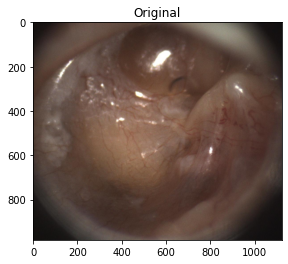

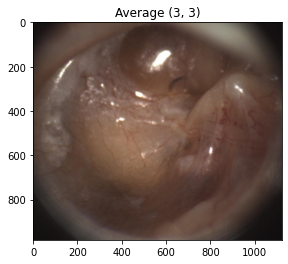

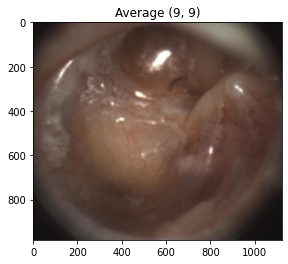

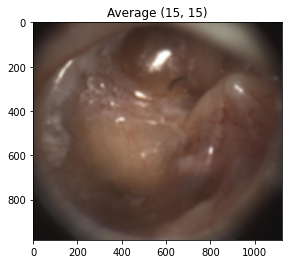

In [ ]:
# load the image, display it to our screen, and initialize a list of
# kernel sizes (so we can evaluate the relationship between kernel
# size and amount of blurring)
image = cv2.imread(args["image"])
plt_imshow("Original", image)
kernelSizes = [(3, 3), (9, 9), (15, 15)]

# loop over the kernel sizes
for (kX, kY) in kernelSizes:
	# apply an "average" blur to the image using the current kernel
	# size
	blurred = cv2.blur(image, (kX, kY))
	plt_imshow("Average ({}, {})".format(kX, kY), blurred)

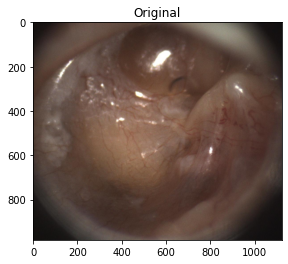

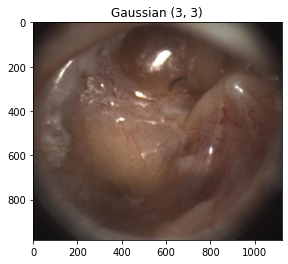

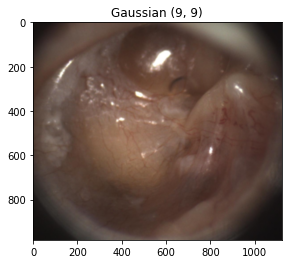

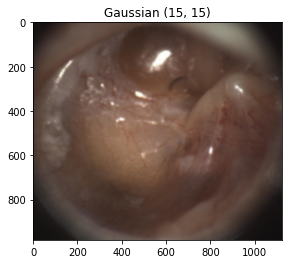

In [ ]:
# display the original image
plt_imshow("Original", image)

# loop over the kernel sizes again
for (kX, kY) in kernelSizes:
	# apply a "Gaussian" blur to the image
	blurred = cv2.GaussianBlur(image, (kX, kY), 0)
	plt_imshow("Gaussian ({}, {})".format(kX, kY), blurred)

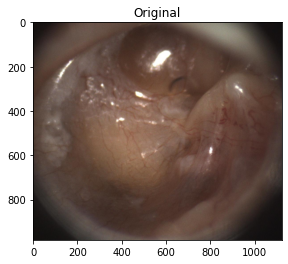

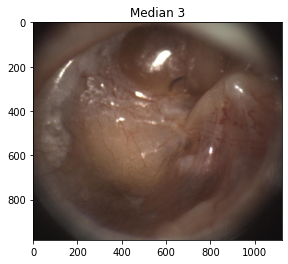

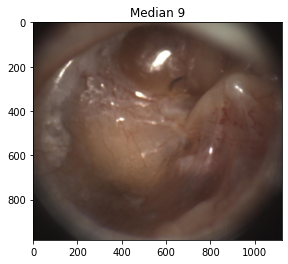

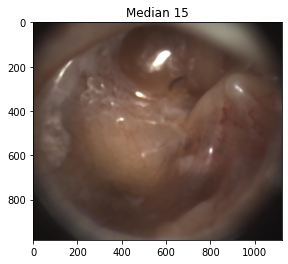

In [ ]:
# display the original image
plt_imshow("Original", image)

# loop over the kernel sizes a final time
for k in (3, 9, 15):
	# apply a "median" blur to the image
	blurred = cv2.medianBlur(image, k)
	plt_imshow("Median {}".format(k), blurred)

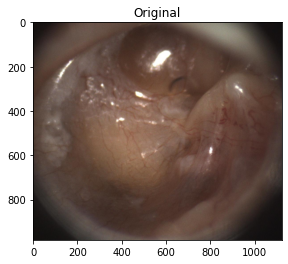

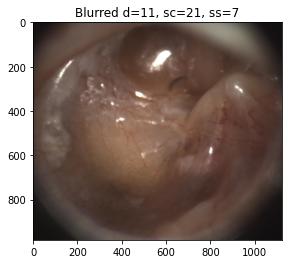

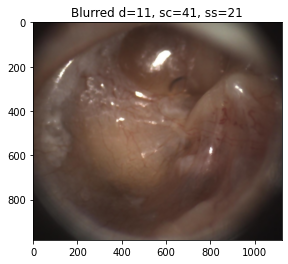

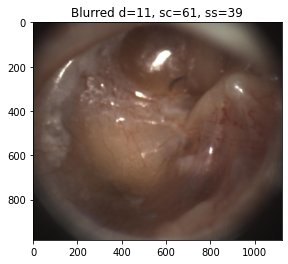

In [ ]:
# load the image, display it to our screen, and construct a list of
# bilateral filtering parameters that we are going to explore
image = cv2.imread(args["image"])
plt_imshow("Original", image)
params = [(11, 21, 7), (11, 41, 21), (11, 61, 39)]

# loop over the diameter, sigma color, and sigma space
for (diameter, sigmaColor, sigmaSpace) in params:
	# apply bilateral filtering to the image using the current set of
	# parameters
	blurred = cv2.bilateralFilter(image, diameter, sigmaColor, sigmaSpace)

	# show the output image and associated parameters
	title = "Blurred d={}, sc={}, ss={}".format(
		diameter, sigmaColor, sigmaSpace)
	plt_imshow(title, blurred)

# Thresholding

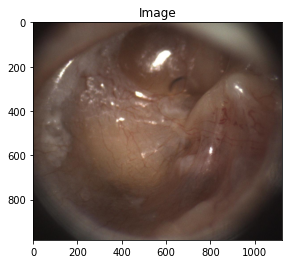

In [ ]:
# load the image and display it
image = cv2.imread(args["image"])
plt_imshow("Image", image)

In [ ]:
# convert the image to grayscale and blur it slightly
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

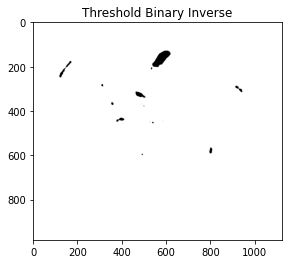

In [ ]:
# apply basic thresholding -- the first parameter is the image
# we want to threshold, the second value is is our threshold
# check; if a pixel value is greater than our threshold (in this
# case, 200), we set it to be *black, otherwise it is *white*
(T, threshInv) = cv2.threshold(blurred, 200, 255,
	cv2.THRESH_BINARY_INV)
plt_imshow("Threshold Binary Inverse", threshInv)

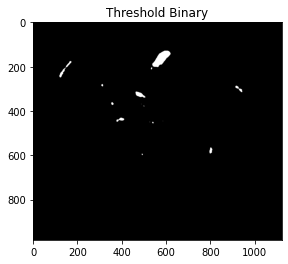

In [ ]:
# using normal thresholding (rather than inverse thresholding)
(T, thresh) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
plt_imshow("Threshold Binary", thresh)

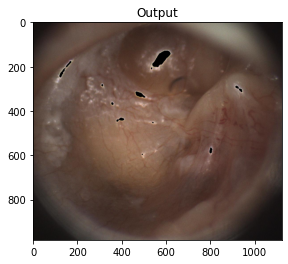

In [ ]:
# visualize only the masked regions in the image
masked = cv2.bitwise_and(image, image, mask=threshInv)
plt_imshow("Output", masked)

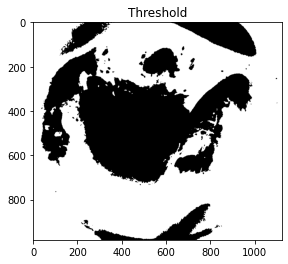

[INFO] otsu's thresholding value: 85.0


In [ ]:
# apply Otsu's automatic thresholding which automatically determines
# the best threshold value
(T, threshInv) = cv2.threshold(blurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt_imshow("Threshold", threshInv)
print("[INFO] otsu's thresholding value: {}".format(T))

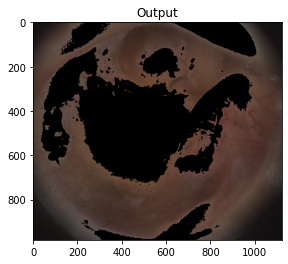

In [ ]:
# visualize only the masked regions in the image
masked = cv2.bitwise_and(image, image, mask=threshInv)
plt_imshow("Output", masked)